In [1]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [2]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA, RANDOM_STATE

# Data import 

In [3]:
#Parameters
YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = True
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

#Warnings
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

#Parameters check
ALLOWED_YEARS = [2017, 2018, 2023]
if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

# Directories for linear model coefficients
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_EDA = DIR_MONTH / "00_eda"

PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

In [4]:
sect = pd.read_csv(DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH))
sect.set_index("Tag", inplace=True)
sect.drop(["N_district", "N_neighbourhood", "N_section", "Airbnb_Price", "Airbnb_Price_Person", "Airbnb_Location_Score","Percentage_Age_25_39"], axis=1, inplace=True)

X = sect.drop(VARIABLE_TO_PREDICT, axis=1)
y = sect[VARIABLE_TO_PREDICT]

geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)
# geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

In [5]:
sect2 = sect.reset_index()
merged_df = geo_info.merge(sect2, on='Tag')
merged_df.head()

Tag                                           geometry  Distance_Center  \
0  01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...         1.532922   
1  01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...         1.060772   
2  01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...         1.262231   
3  01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...         1.180517   
4  01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...         0.937494   

   POI_Daily_Food  POI_Daily_Others  POI_House_Equipment  POI_Clothing  \
0               6                 1                    0             0   
1               3                 2                    1             2   
2               9                 3                    1             2   
3              13                 4                    8             2   
4              20                 4                    2             2   

   POI_Culture  POI_Vehicles  POI_State_Agents  ...  Nationality_Armenia  \
0            2             0                 0  ...             0.000000   
1            1             0                 0  ...             0.005000   
2            3             0                 0  ...             0.000288   
3            5             0                 2  ...             0.000340   
4           38             0                 0  ...             0.001283   

   Nationality_Japan  Nationality_Nepal  Nationality_Turkey  Nationality_Iran  \
0           0.000768           0.000768            0.000768          0.000000   
1           0.000000           0.000000            0.002143          0.000000   
2           0.000865           0.004038            0.000865          0.000000   
3           0.001019           0.001358            0.004414          0.000679   
4           0.000000           0.001711            0.002566          0.001711   

   Nationality_Oceania  Rent_Number_Flats  Rent_Price_Meter_Flats  \
0             0.000000              107.0               13.228132   
1             0.000714               65.0               13.080019   
2             0.000288              164.0               14.000000   
3             0.000000              160.0               13.207547   
4             0.000000              107.0               11.695734   

   Rent_Price_Total_Flats  Rent_Area_Flats  
0                   769.0             57.0  
1                   867.0             65.0  
2                   700.0             50.0  
3                   750.0             55.0  
4                   722.0             65.0  

[5 rows x 87 columns]

# NANs

(Comentar Imputation - KNNImputer)

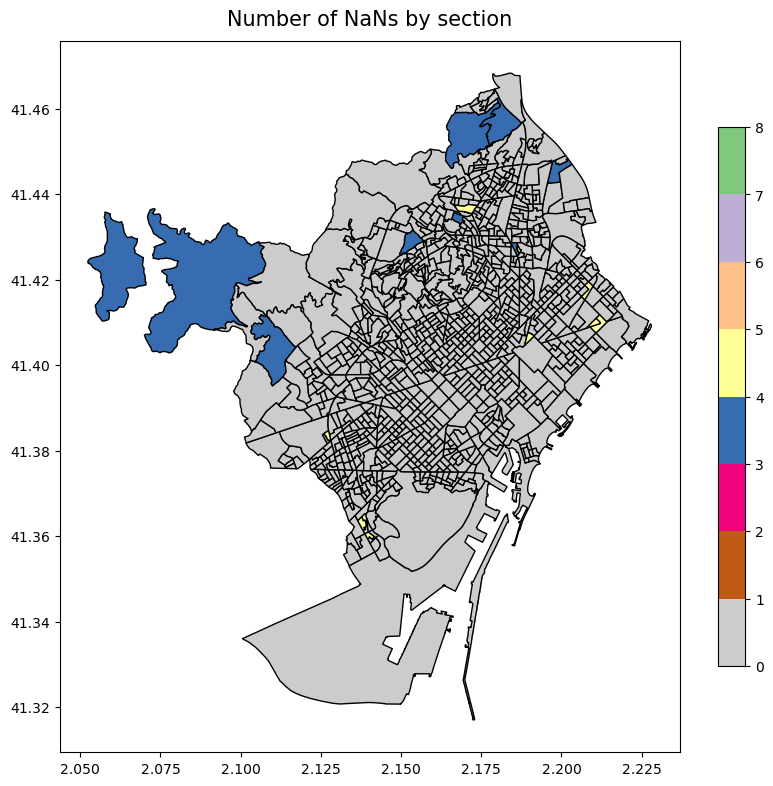

In [6]:
# Colormap
cmap = plt.cm.Accent_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]  # extract all colors from the .jet map
cmaplist[0] = "0.8"  # force the first color entry to be grey
bounds = np.linspace(0, 8, 9)  # define the bins and normalize
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

geo_nans = geo_info.copy()
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 10))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=15, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_EDA / "nans.png", format="png")

plt.show()

# Inspecting Data

In [7]:
# print(sect.info())
#print(geo_info.info())

#print(sect.describe())
#print(geo_info.describe())

# print(sect.shape)
# print(geo_info.shape)

## Dataframes heads

In [8]:
pd.set_option('display.max_columns', None)

sect.head()

Distance_Center  POI_Daily_Food  POI_Daily_Others  \
Tag                                                         
01_001         1.532922               6                 1   
01_002         1.060772               3                 2   
01_003         1.262231               9                 3   
01_004         1.180517              13                 4   
01_005         0.937494              20                 4   

        POI_House_Equipment  POI_Clothing  POI_Culture  POI_Vehicles  \
Tag                                                                    
01_001                    0             0            2             0   
01_002                    1             2            1             0   
01_003                    1             2            3             0   
01_004                    8             2            5             0   
01_005                    2             2           38             0   

        POI_State_Agents  POI_Education  POI_Finances  POI_Restaurants_Hotels  \
Tag                                                                             
01_001                 0              4             0                      33   
01_002                 0              2             0                      19   
01_003                 0              5             2                      20   
01_004                 2              3             3                      36   
01_005                 0              0             1                      42   

        POI_Health  POI_Souvenirs_Thrift_Store  POI_Car_Parks  POI_Esthetics  \
Tag                                                                            
01_001           2                           8              1              1   
01_002           0                           3              0              5   
01_003           3                           1              2              3   
01_004           1                           3              1              9   
01_005           1                          15              1             11   

        POI_Sports  POI_Religion  POI_Administration  Airbnb_Number  \
Tag                                                                   
01_001           1             1                   4             76   
01_002           0             0                   0             61   
01_003           1             0                   1             50   
01_004           1             2                   3             82   
01_005           0             0                   2            108   

        Percentage_Gender_Female  Percentage_Age_0_14  Percentage_Age_15_24  \
Tag                                                                           
01_001                  0.464203             0.123172              0.087760   
01_002                  0.486604             0.101376              0.126720   
01_003                  0.458248             0.200466              0.130637   
01_004                  0.450767             0.122317              0.111414   
01_005                  0.460146             0.118053              0.112452   

        Percentage_Age_40_64  Percentage_Age_65_Plus  Household  \
Tag                                                               
01_001              0.318707                0.143957       2.52   
01_002              0.281680                0.133961       2.60   
01_003              0.291824                0.108525       3.23   
01_004              0.329472                0.100170       2.65   
01_005              0.326583                0.126239       2.45   

        Education_None  Education_Primary_School  Education_Middle_School  \
Tag                                                                         
01_001        0.011474                  0.211827                 0.248897   
01_002        0.023200                  0.220800                 0.251200   
01_003        0.012806                  0.296744                 0.256129   
01_004        0.010937                 

In [9]:
geo_info.head()

geometry
Tag                                                      
01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...
01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...
01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...
01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...
01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...

# Descriptive Statistics, Visualization

## Correlation

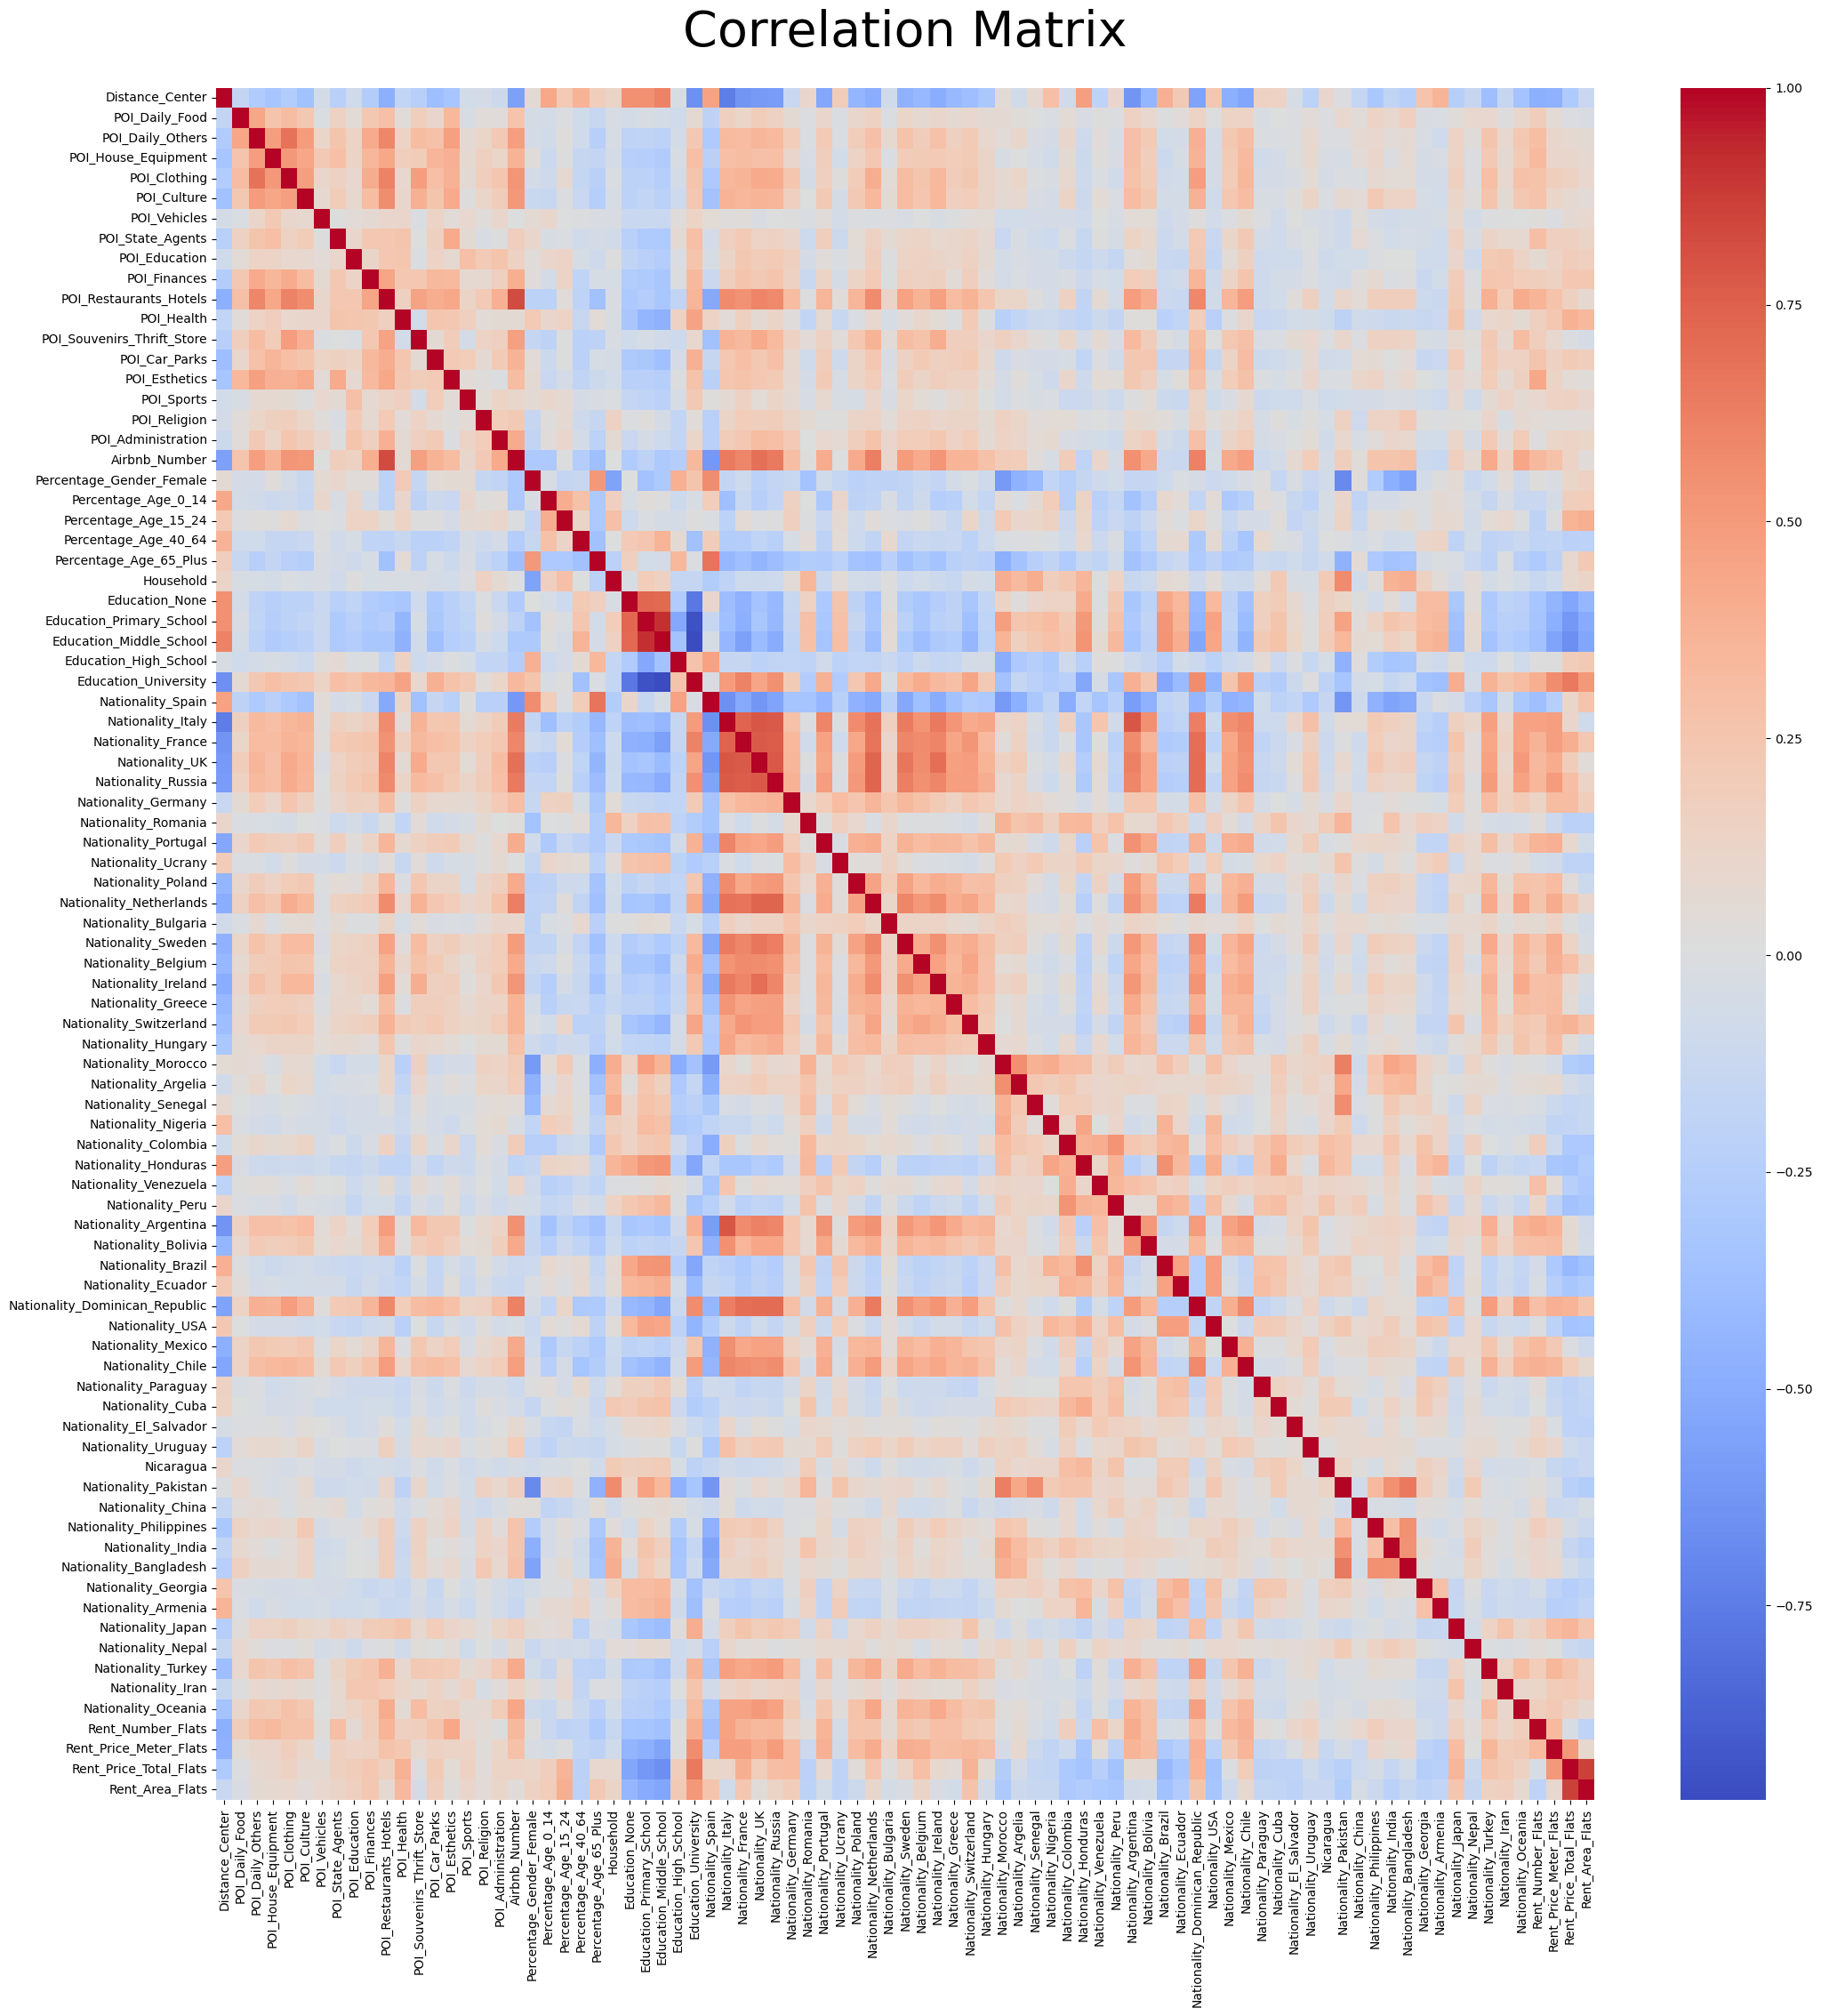

In [10]:
corr_matrix = sect.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=40, y=1.02)

if SAVE_FIGS:
    plt.savefig(DIR_EDA / "corr_matrix.png", format="png")

plt.show()

In [11]:
airbnb_corr = corr_matrix['Airbnb_Number']
significant_corr = airbnb_corr[(airbnb_corr.abs() > 0.5) & (airbnb_corr.index != 'Airbnb_Number')]

significant_corr_df = significant_corr.reset_index()
significant_corr_df.columns = ['Variable', 'Correlation']

significant_corr_df = significant_corr_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
significant_corr_df

# from tabulate import tabulate
# latex_table = tabulate(significant_corr_df, headers='keys', tablefmt='latex', showindex=False)
# print(latex_table)

Variable  Correlation
0           POI_Restaurants_Hotels     0.826464
1                   Nationality_UK     0.687069
2               Nationality_Russia     0.646595
3                Nationality_Italy     0.642170
4          Nationality_Netherlands     0.622905
5   Nationality_Dominican_Republic     0.615714
6               Nationality_France     0.597006
7            Nationality_Argentina     0.549475
8                     POI_Clothing     0.526814
9              Nationality_Ireland     0.525658
10                     POI_Culture     0.513308
11                 Distance_Center    -0.567907
12               Nationality_Spain    -0.618425

In [12]:
# sect_melted = sect.melt(var_name='Variable', value_name='Value')

# # Create the box plot
# plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
# sns.boxplot(x='Variable', y='Value', data=sect_melted)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.title('Box Plot of All Variables in sect')
# plt.tight_layout()
# plt.show()

# Target Variable distribution

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

def plot_var_map_log(var): 

    norm = mcolors.LogNorm(vmin=merged_df[var].min() + 1, vmax=merged_df[var].max())

    
    fig, ax = plt.subplots(figsize=(10, 10))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.75)
    im = merged_df.plot(
        ax=ax,
        column=var,
        legend=True,
        cmap="YlGnBu",  # Use the YlGnBu colormap
        norm=norm,  # Apply logarithmic normalization
        legend_kwds={"shrink": 0.7, "label": str(var)},
        cax=cax,
    )

    cbar = plt.colorbar(im.get_children()[0], cax=cax)
    cbar.set_label(str(var))

    ticks = [1, 10, 50, 100, 200, 350]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t}" for t in ticks])

    x, y, arrow_length = 0.95, 0.1, 0.07
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=2, headwidth=5),
        ha="center",
        va="center",
        fontsize=10,
        xycoords=ax.transAxes,
    )

    ax.set_title(
        str(var) + " value in the different sections", fontsize=15, y=1.01
    )

    if SAVE_FIGS is True:
        dir = str(var)+"_variable_map.png"
        plt.savefig(DIR_EDA / dir, format="png")

    plt.show()

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_var_map(var): 
    
    fig, ax = plt.subplots(figsize=(10, 10))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.75)
    merged_df.plot(
        ax=ax,
        column=var,
        legend=True,
        cmap="YlGnBu",
        legend_kwds={"shrink": 0.7, "label": str(var)},
        cax=cax,
    )

    x, y, arrow_length = 0.95, 0.1, 0.07
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=2, headwidth=5),
        ha="center",
        va="center",
        fontsize=10,
        xycoords=ax.transAxes,
    )

    ax.set_title(
        str(var) + " value in the census sections", fontsize=15, y=1.01
    )

    if SAVE_FIGS is True:
        dir = str(var)+"_variable_map.png"
        plt.savefig(DIR_EDA / dir, format="png")

    plt.show()

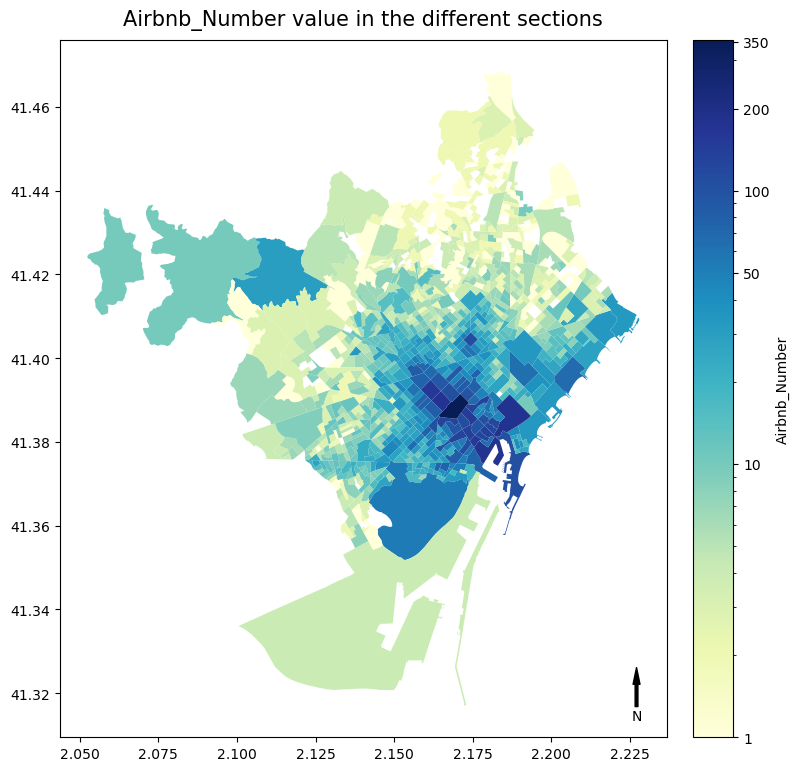

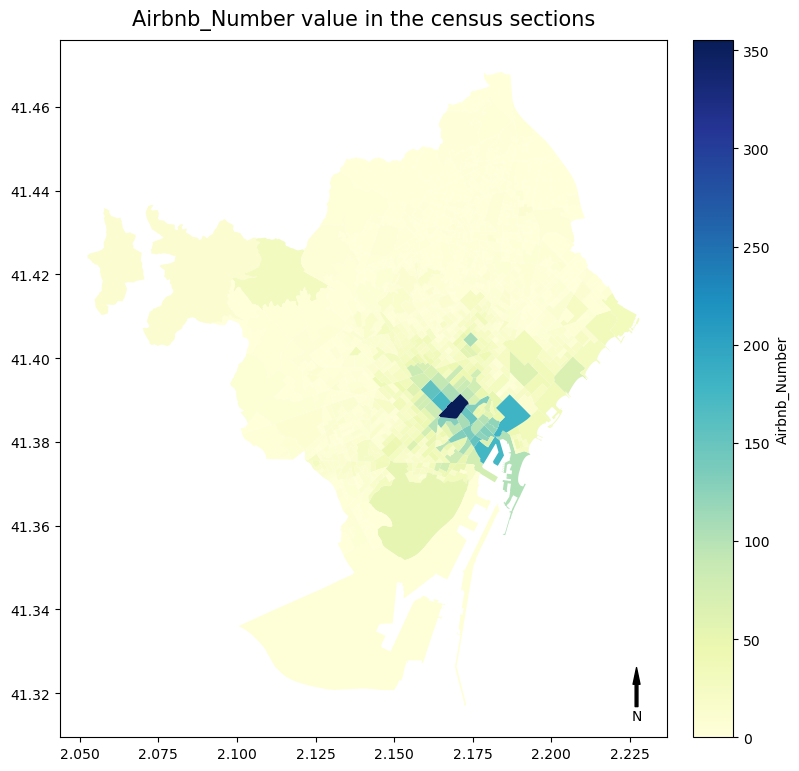

In [41]:
plot_var_map_log(VARIABLE_TO_PREDICT)
plot_var_map(VARIABLE_TO_PREDICT)

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

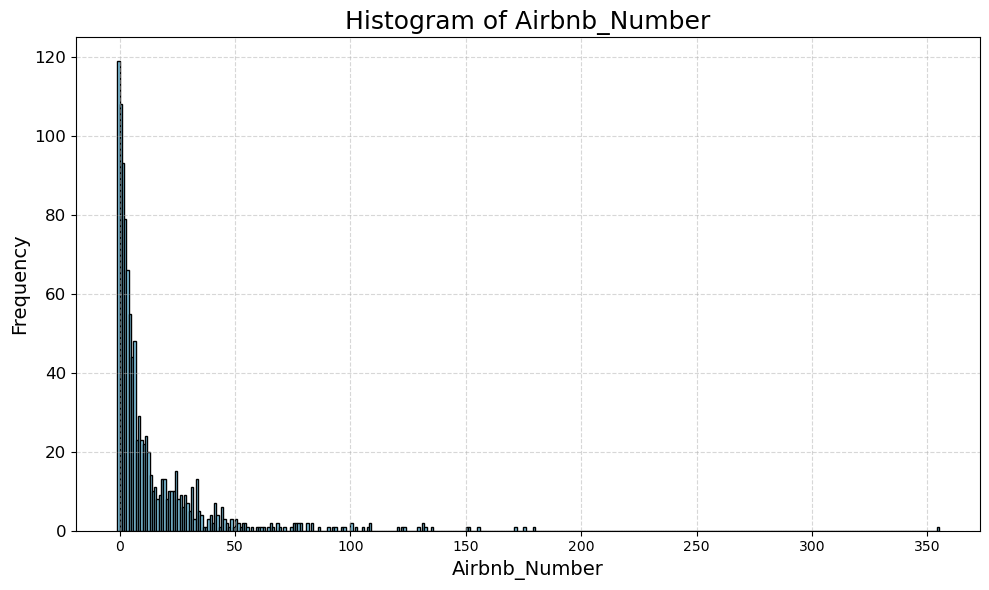

In [53]:
counts, bin_edges = np.histogram(merged_df[VARIABLE_TO_PREDICT], bins=np.arange(merged_df[VARIABLE_TO_PREDICT].min(), merged_df[VARIABLE_TO_PREDICT].max() + 2) - 0.5)

fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(bin_edges[:-1], counts, width=1, edgecolor="black", color='skyblue')

ax.set_title("Histogram of " + str(VARIABLE_TO_PREDICT), fontsize=18)
ax.set_xlabel(VARIABLE_TO_PREDICT, fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

ax.grid(True, linestyle='--', alpha=0.5)

ax.tick_params(axis='x', labelsize=10) 
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

plt.tight_layout()

SAVE_FIGS = True
if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "target_variable_distrib.png", format="png")
SAVE_FIGS = False

plt.show()


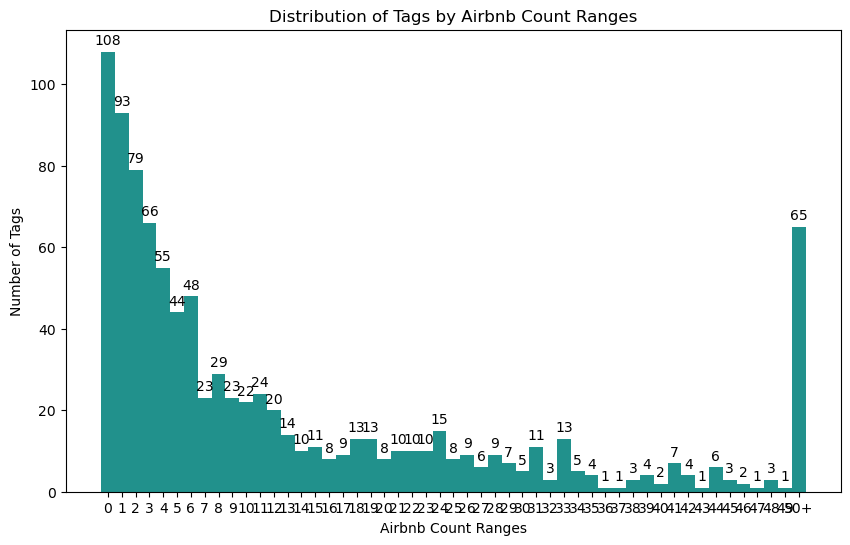

In [17]:
# bin_step = 1
# max_value = 50
# bins = list(range(0, max_value + bin_step, bin_step)) + [float('inf')]
# #labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-2)] + [f"{bins[-2]}+"]
# labels = [f"{bins[i]}" for i in range(len(bins)-2)] + [f"{bins[-2]}+"]

# geo_info_rep = merged_df

# geo_info_rep["Airbnb_Range"] = pd.cut(
#     merged_df["Airbnb_Number"], bins=bins, labels=labels)

# tag_counts = merged_df.groupby("Airbnb_Range")["Tag"].count()

# plt.figure(figsize=(10, 6))
# uniform_color = sns.color_palette("viridis", 1)[0]  # Get a single color from the viridis palette

# positions = np.arange(len(tag_counts)) * 5
# bars = plt.bar(positions, tag_counts.values, color=uniform_color, width=5)

# for bar in bars:
#     height = bar.get_height()
#     plt.annotate('{}'.format(height),
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),  # 3 points vertical offset
#                  textcoords="offset points",
#                  ha='center', va='bottom')

# plt.xlabel("Airbnb Count Ranges")
# plt.ylabel("Number of Tags")
# plt.title("Distribution of Tags by Airbnb Count Ranges")

# plt.xticks(positions, labels, rotation=0, ha='center')

# if SAVE_FIGS is True:
#     plt.savefig(DIR_EDA / "target_variable_distrib.png", format="png")

# plt.show()

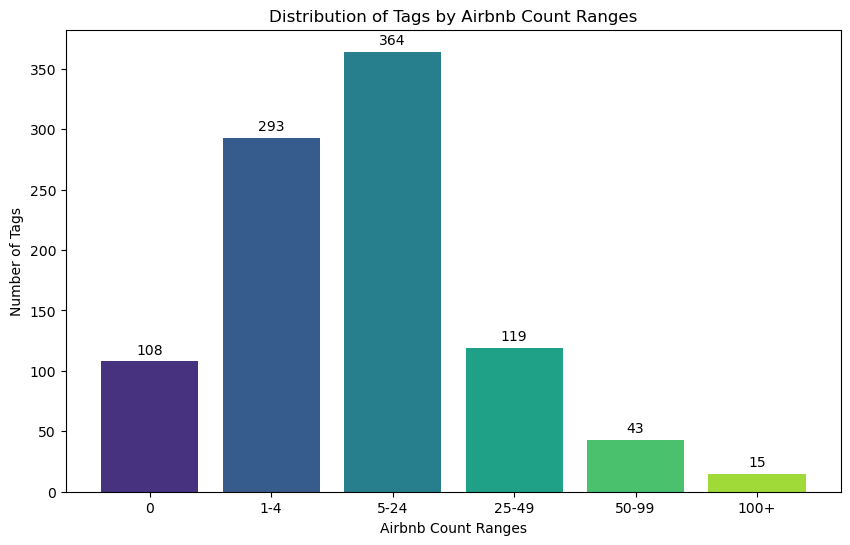

In [18]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0", "1-4", "5-24", "25-49", "50-99", "100+"]

geo_info_rep = merged_df

geo_info_rep["Airbnb_Range"] = pd.cut(
    merged_df["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = merged_df.groupby("Airbnb_Range")["Tag"].count()

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(tag_counts))
bars = plt.bar(tag_counts.index, tag_counts.values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "target_variable_distrib.png", format="png")

plt.show()

## Spanish Nat dist map

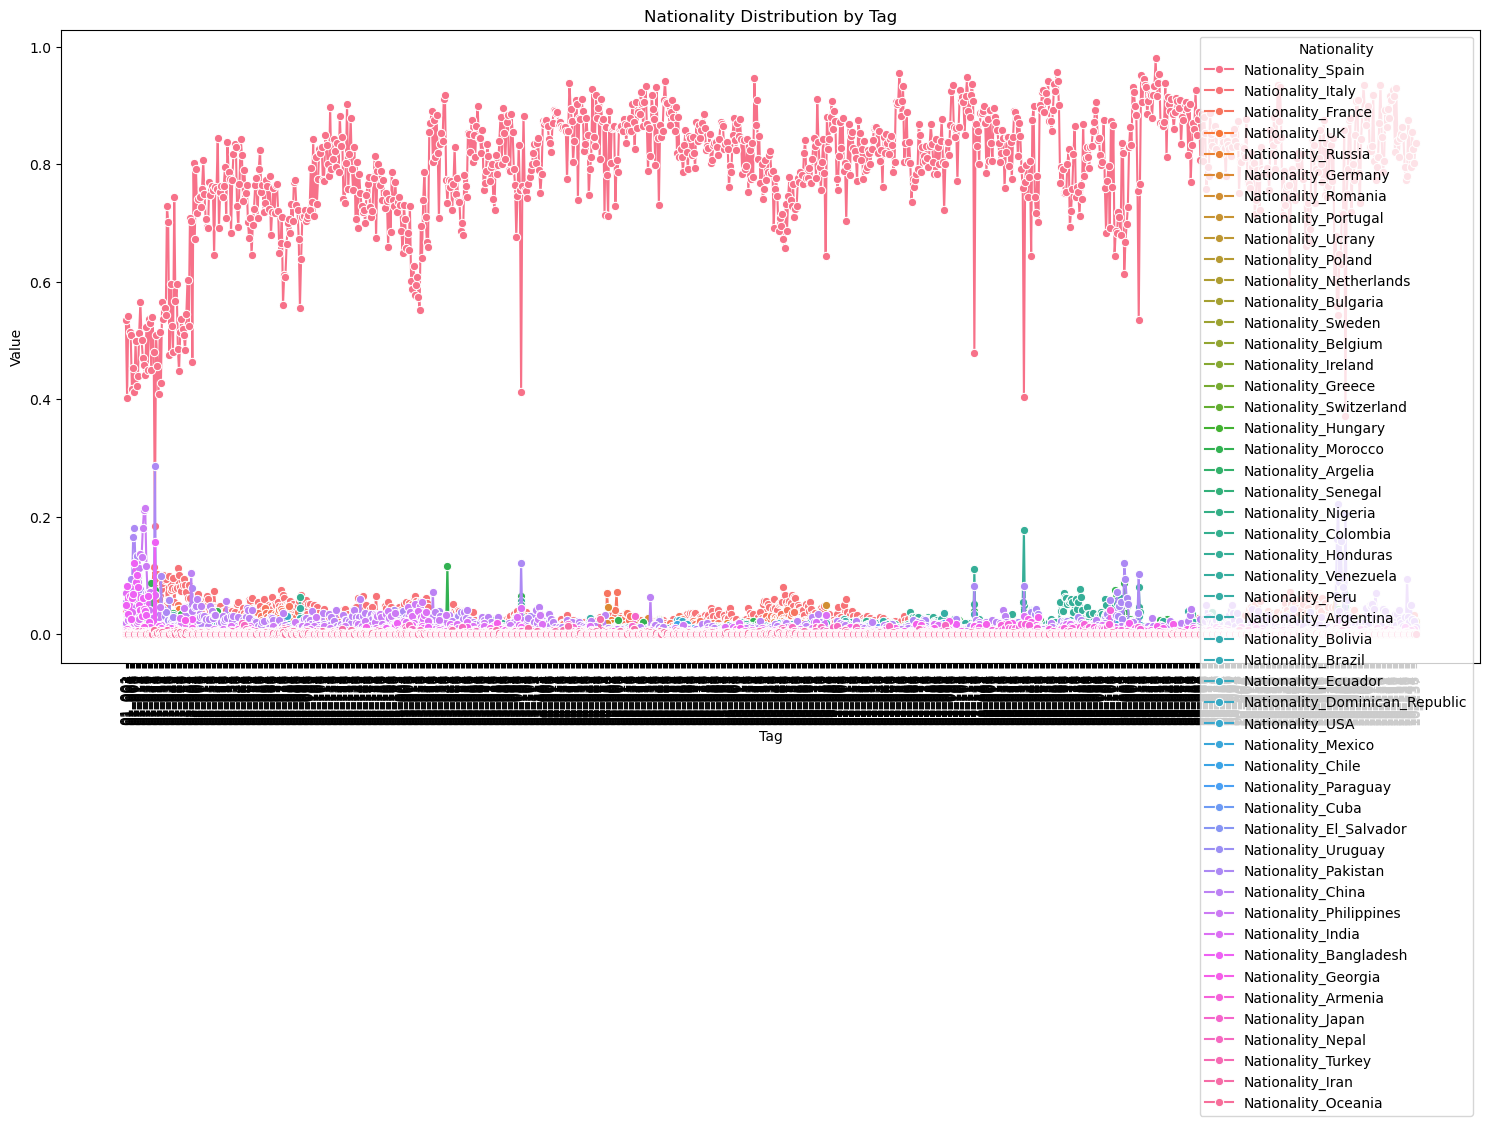

In [19]:
nationality_cols = [col for col in sect2.columns if col.startswith('Nationality_')]
sect_nationalities = sect2[['Tag'] + nationality_cols]
sect_melted = sect_nationalities.melt(id_vars='Tag', var_name='Nationality', value_name='Value')

plt.figure(figsize=(15, 10))
sns.lineplot(data=sect_melted, x='Tag', y='Value', hue='Nationality', marker='o')
plt.title('Nationality Distribution by Tag')
plt.xlabel('Tag')
plt.ylabel('Value')
plt.legend(title='Nationality')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

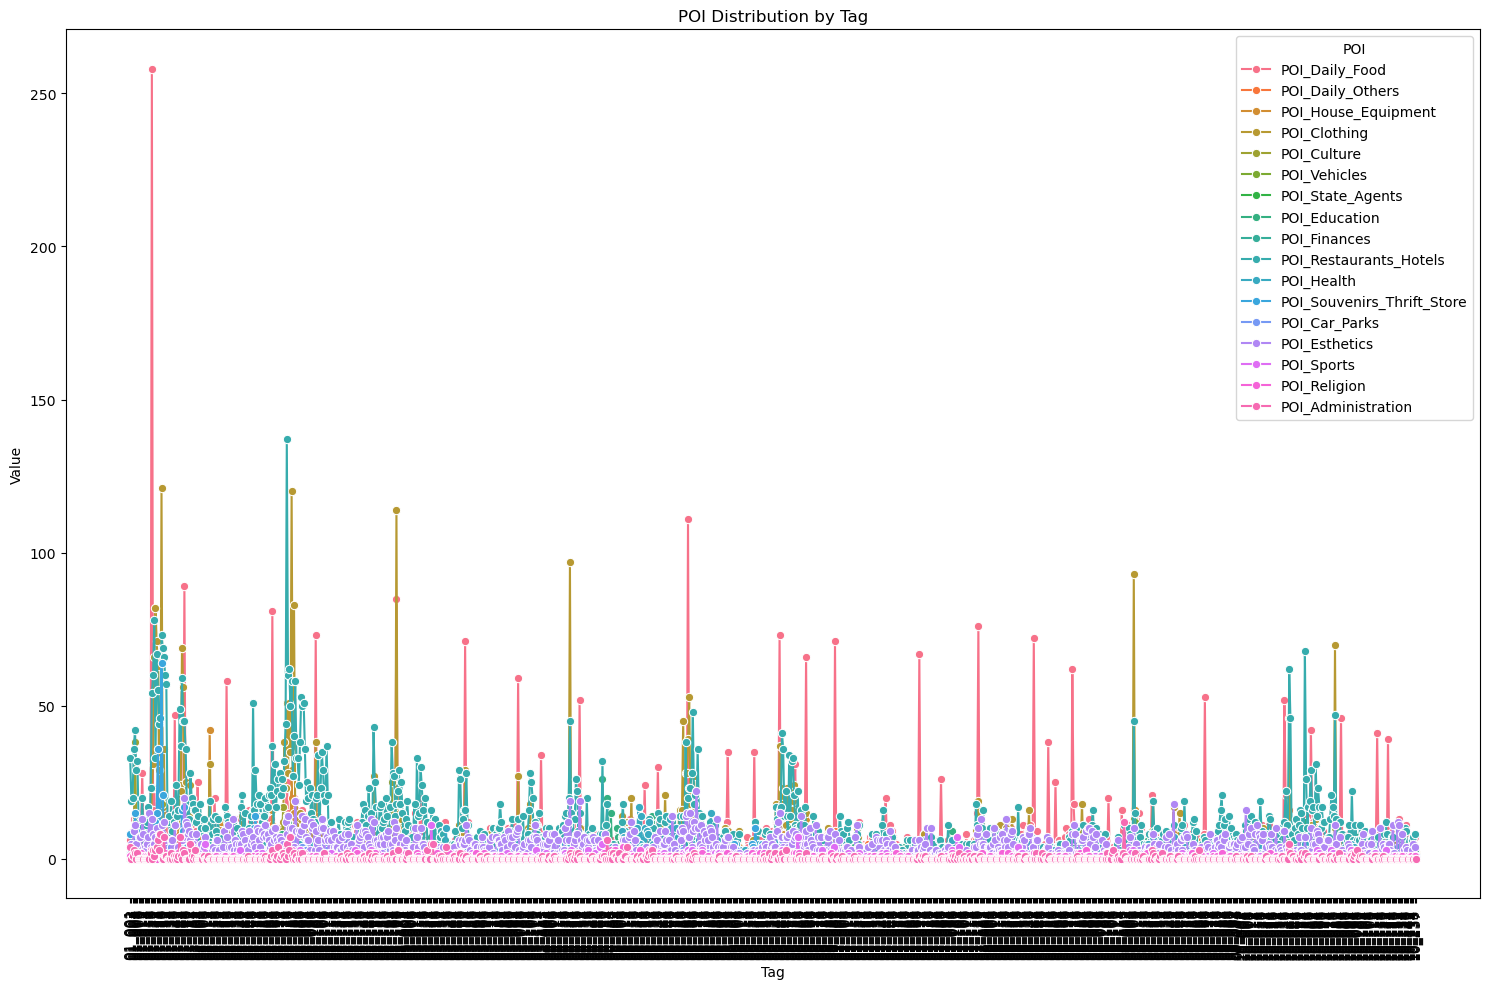

In [20]:
poi_cols = [col for col in sect2.columns if col.startswith('POI_')]
sect_poi = sect2[['Tag'] + poi_cols]

sect_melted = sect_poi.melt(id_vars='Tag', var_name='POI', value_name='Value')

plt.figure(figsize=(15, 10))
sns.lineplot(data=sect_melted, x='Tag', y='Value', hue='POI', marker='o')
plt.title('POI Distribution by Tag')
plt.xlabel('Tag')
plt.ylabel('Value')
plt.legend(title='POI')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

## Boxplots of all variables

In [21]:
# # Number of variables
# num_vars = sect.shape[1]

# # Determine the grid size for subplots (e.g., 3 columns)
# num_cols = 3
# num_rows = (num_vars + num_cols - 1) // num_cols

# # Create subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
# axes = axes.flatten()

# # Plot each variable in a separate subplot
# for i, col in enumerate(sect.columns):
#     sns.boxplot(y=sect[col], ax=axes[i])
#     axes[i].set_title(col)

# # Remove empty subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

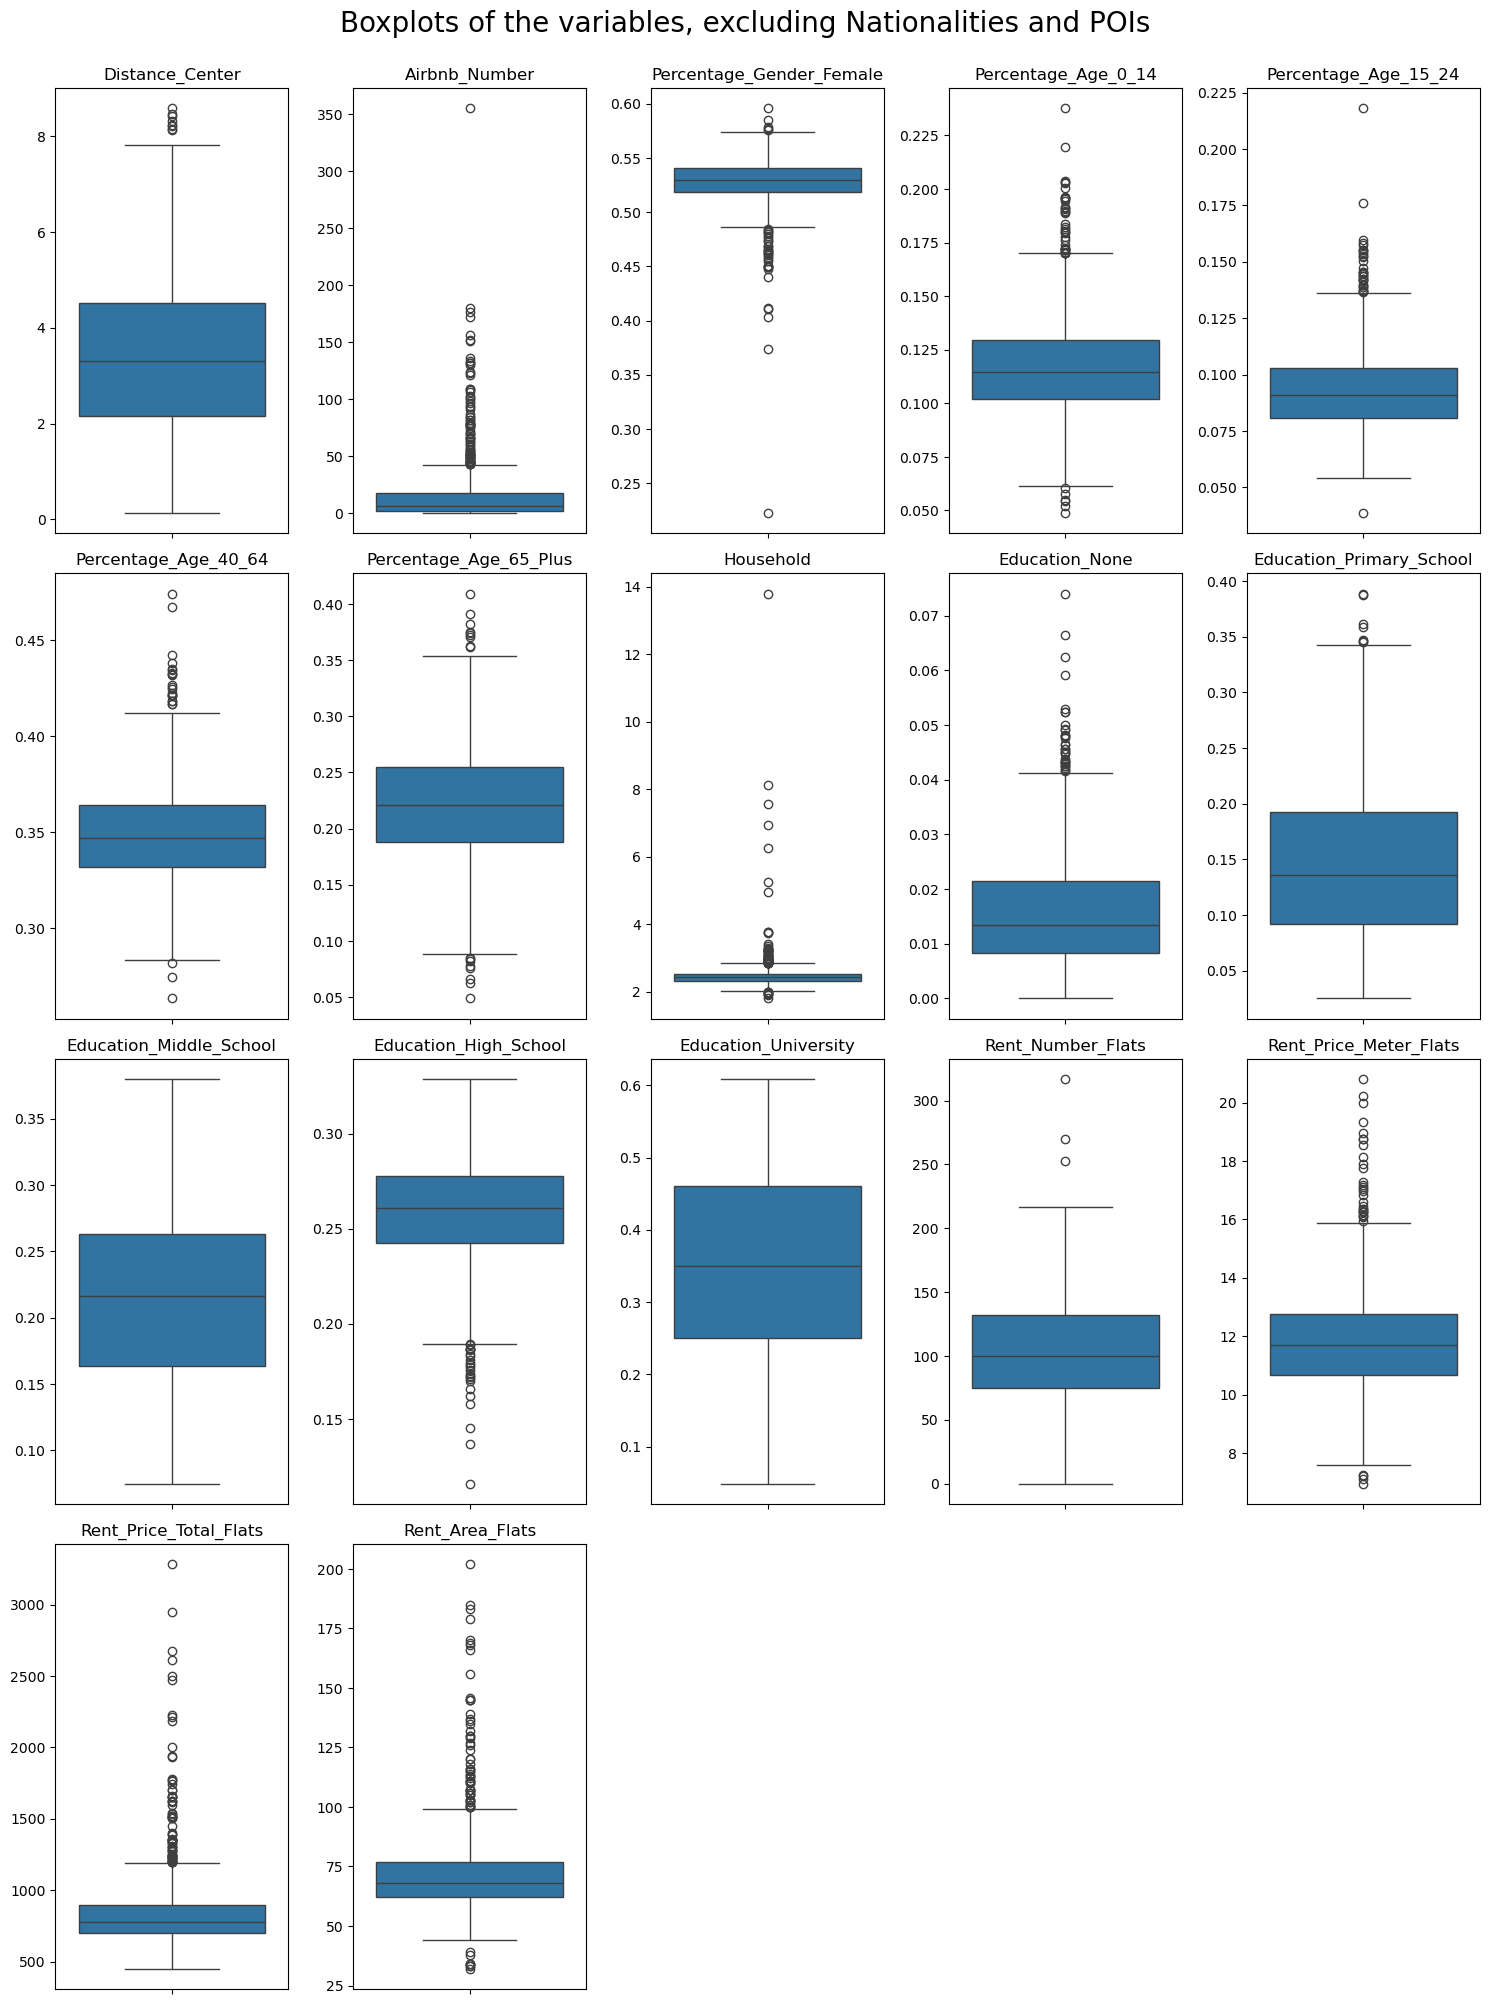

In [22]:
exclude_cols = [col for col in sect2.columns if col.startswith('Nationality_') or col.startswith('POI_') or col=='Tag' or col=='Nicaragua']
include_cols = [col for col in sect2.columns if col not in exclude_cols]
# 'Distance_Center','Airbnb_Number'
# include_cols = ['Percentage_Gender_Female','Percentage_Age_0_14','Percentage_Age_15_24','Percentage_Age_40_64','Percentage_Age_65_Plus',
#  'Education_None','Education_Primary_School','Education_Middle_School','Education_High_School','Education_University',
#  'Rent_Number_Flats','Rent_Price_Meter_Flats','Rent_Price_Total_Flats','Rent_Area_Flats', 'Household']

sect_filtered = sect2[include_cols]

num_vars = sect_filtered.shape[1]
num_cols = 5
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
fig.suptitle('Boxplots of the variables, excluding Nationalities and POIs', fontsize=20, y=1)
axes = axes.flatten()

for i, col in enumerate(sect_filtered.columns):
    sns.boxplot(y=sect_filtered[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "boxplots.png", format="png")

plt.show()

## Boxplots excluding Nat and POIs

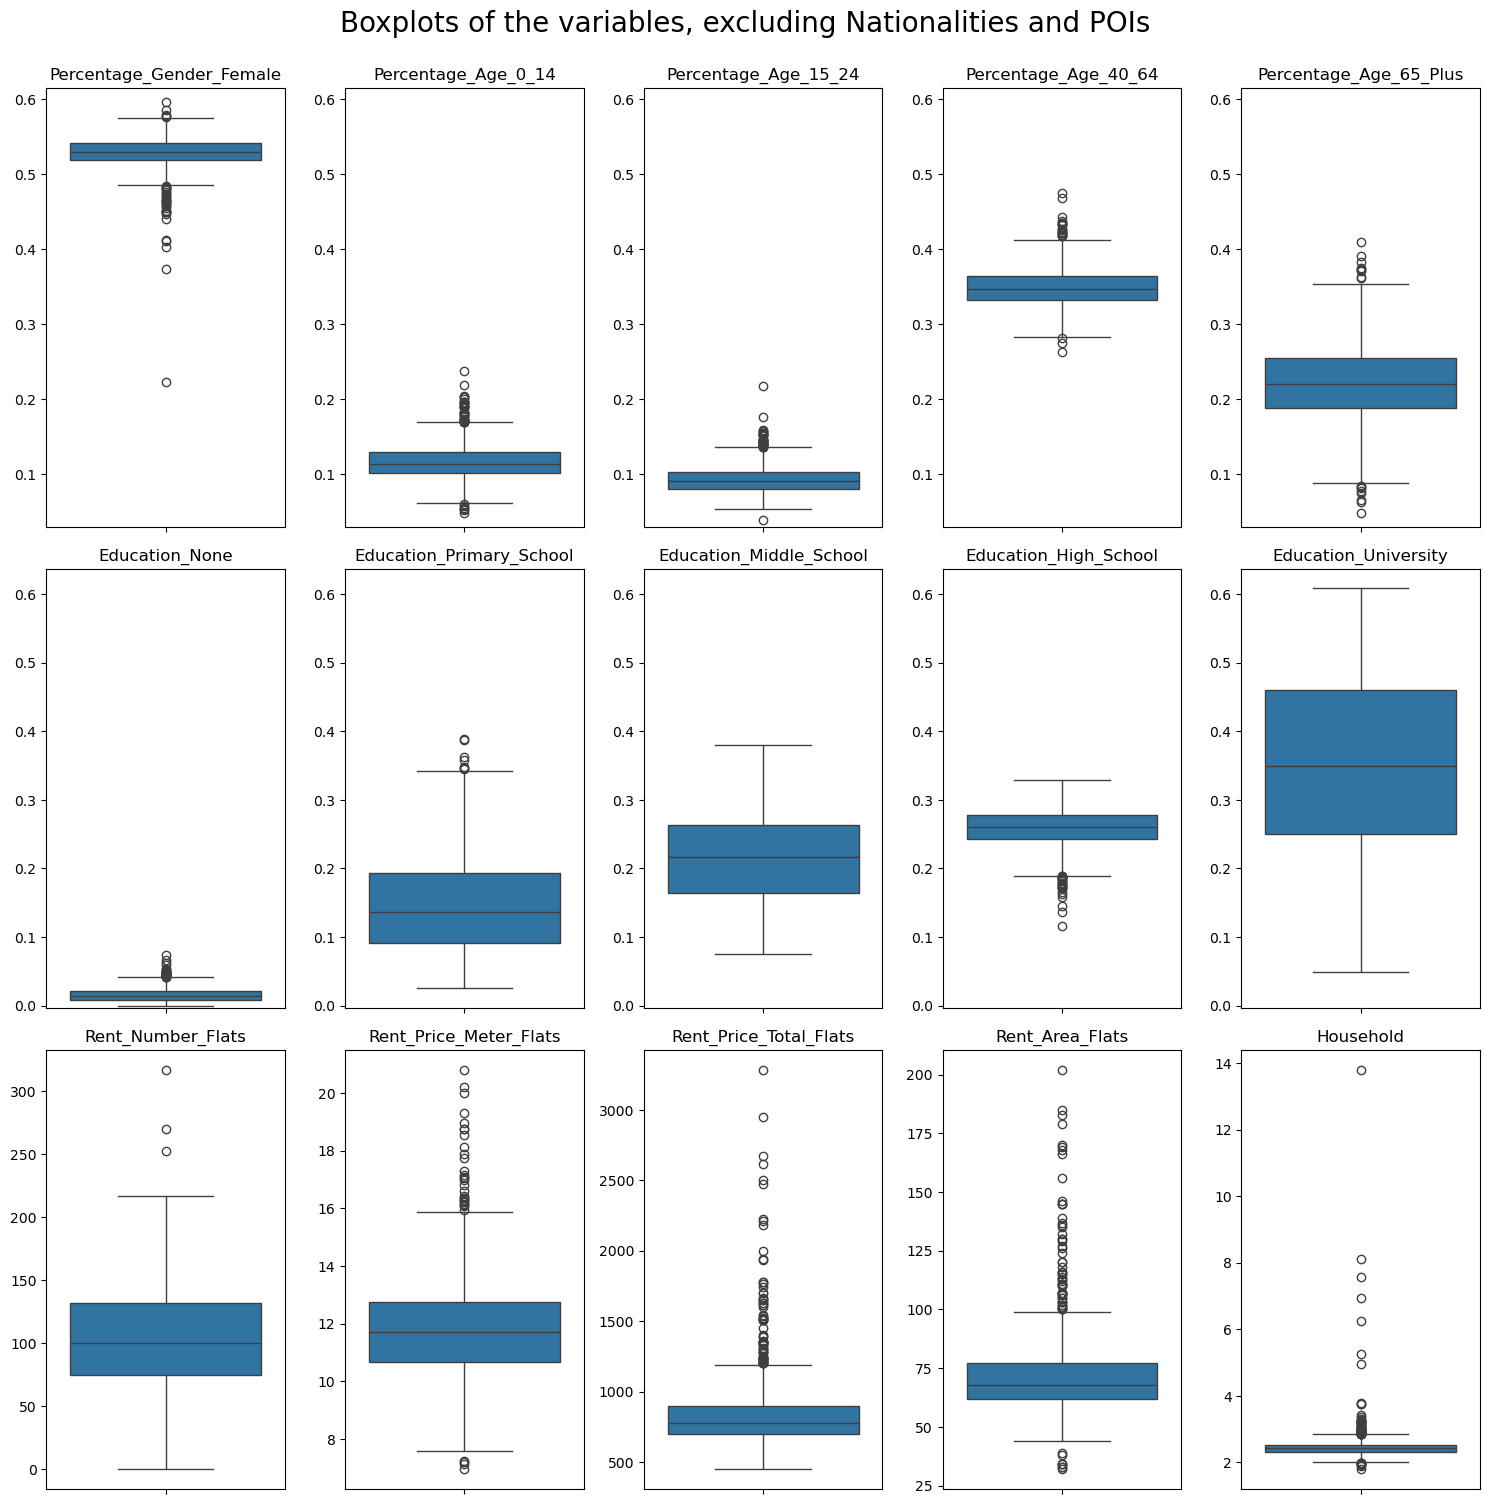

In [23]:
# exclude_cols = [col for col in sect2.columns if col.startswith('Nationality_') or col.startswith('POI_') or col=='Tag' or col=='Nicaragua']
# include_cols = [col for col in sect2.columns if col not in exclude_cols]
# 'Distance_Center','Airbnb_Number'
include_cols = ['Percentage_Gender_Female','Percentage_Age_0_14','Percentage_Age_15_24','Percentage_Age_40_64','Percentage_Age_65_Plus',
 'Education_None','Education_Primary_School','Education_Middle_School','Education_High_School','Education_University',
 'Rent_Number_Flats','Rent_Price_Meter_Flats','Rent_Price_Total_Flats','Rent_Area_Flats', 'Household']

sect_filtered = sect2[include_cols]

num_vars = sect_filtered.shape[1]
num_cols = 5
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
fig.suptitle('Boxplots of the variables, excluding Nationalities and POIs', fontsize=20, y=1)
axes = axes.flatten()

y_limits = []
for i, col in enumerate(sect_filtered.columns):
    sns.boxplot(y=sect_filtered[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')
    y_limits.append(axes[i].get_ylim())

for row in range(num_rows-1):
    row_limits = y_limits[row*num_cols:(row+1)*num_cols]
    min_ylim = min(lim[0] for lim in row_limits)
    max_ylim = max(lim[1] for lim in row_limits)
    for j in range(num_cols):
        if row*num_cols + j < num_vars:
            axes[row*num_cols + j].set_ylim(min_ylim, max_ylim)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "boxplots.png", format="png")

plt.show()

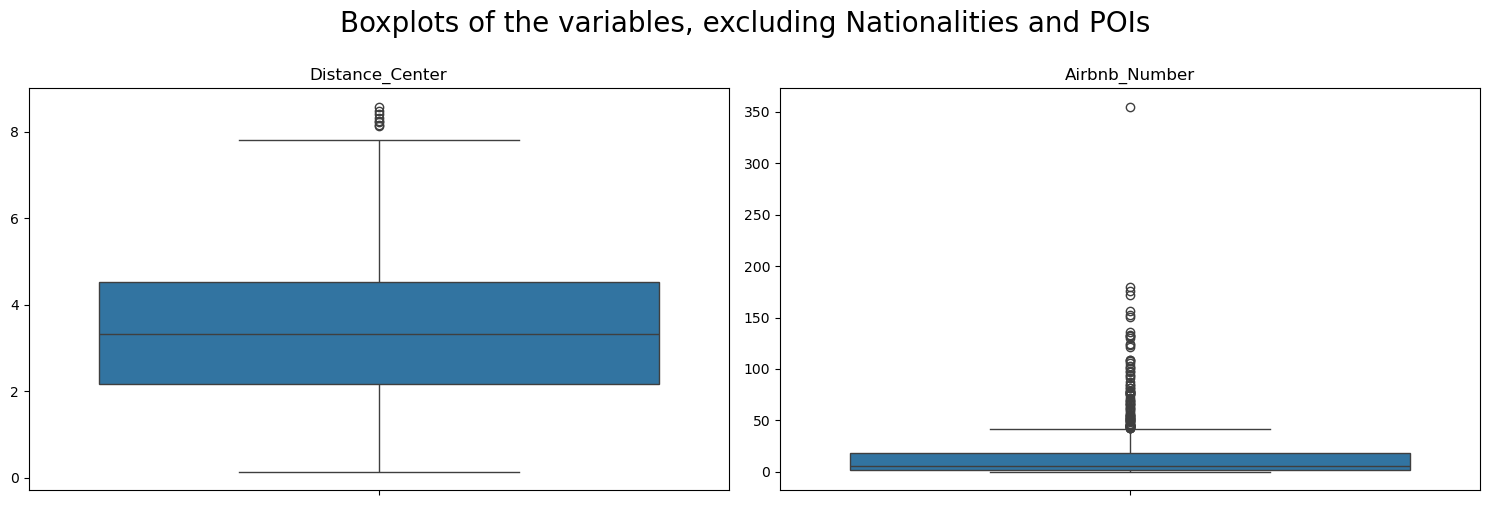

In [24]:
# 'Distance_Center','Airbnb_Number'
# include_cols = ['Percentage_Gender_Female','Percentage_Age_0_14','Percentage_Age_15_24','Percentage_Age_40_64','Percentage_Age_65_Plus',
#  'Education_None','Education_Primary_School','Education_Middle_School','Education_High_School','Education_University',
#  'Rent_Number_Flats','Rent_Price_Meter_Flats','Rent_Price_Total_Flats','Rent_Area_Flats', 'Household']

include_cols = ['Distance_Center','Airbnb_Number']

sect_filtered = sect2[include_cols]

num_vars = sect_filtered.shape[1]
num_cols = 2
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
fig.suptitle('Boxplots of the variables, excluding Nationalities and POIs', fontsize=20, y=1)
axes = axes.flatten()

for i, col in enumerate(sect_filtered.columns):
    sns.boxplot(y=sect_filtered[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "boxplots.png", format="png")

plt.show()

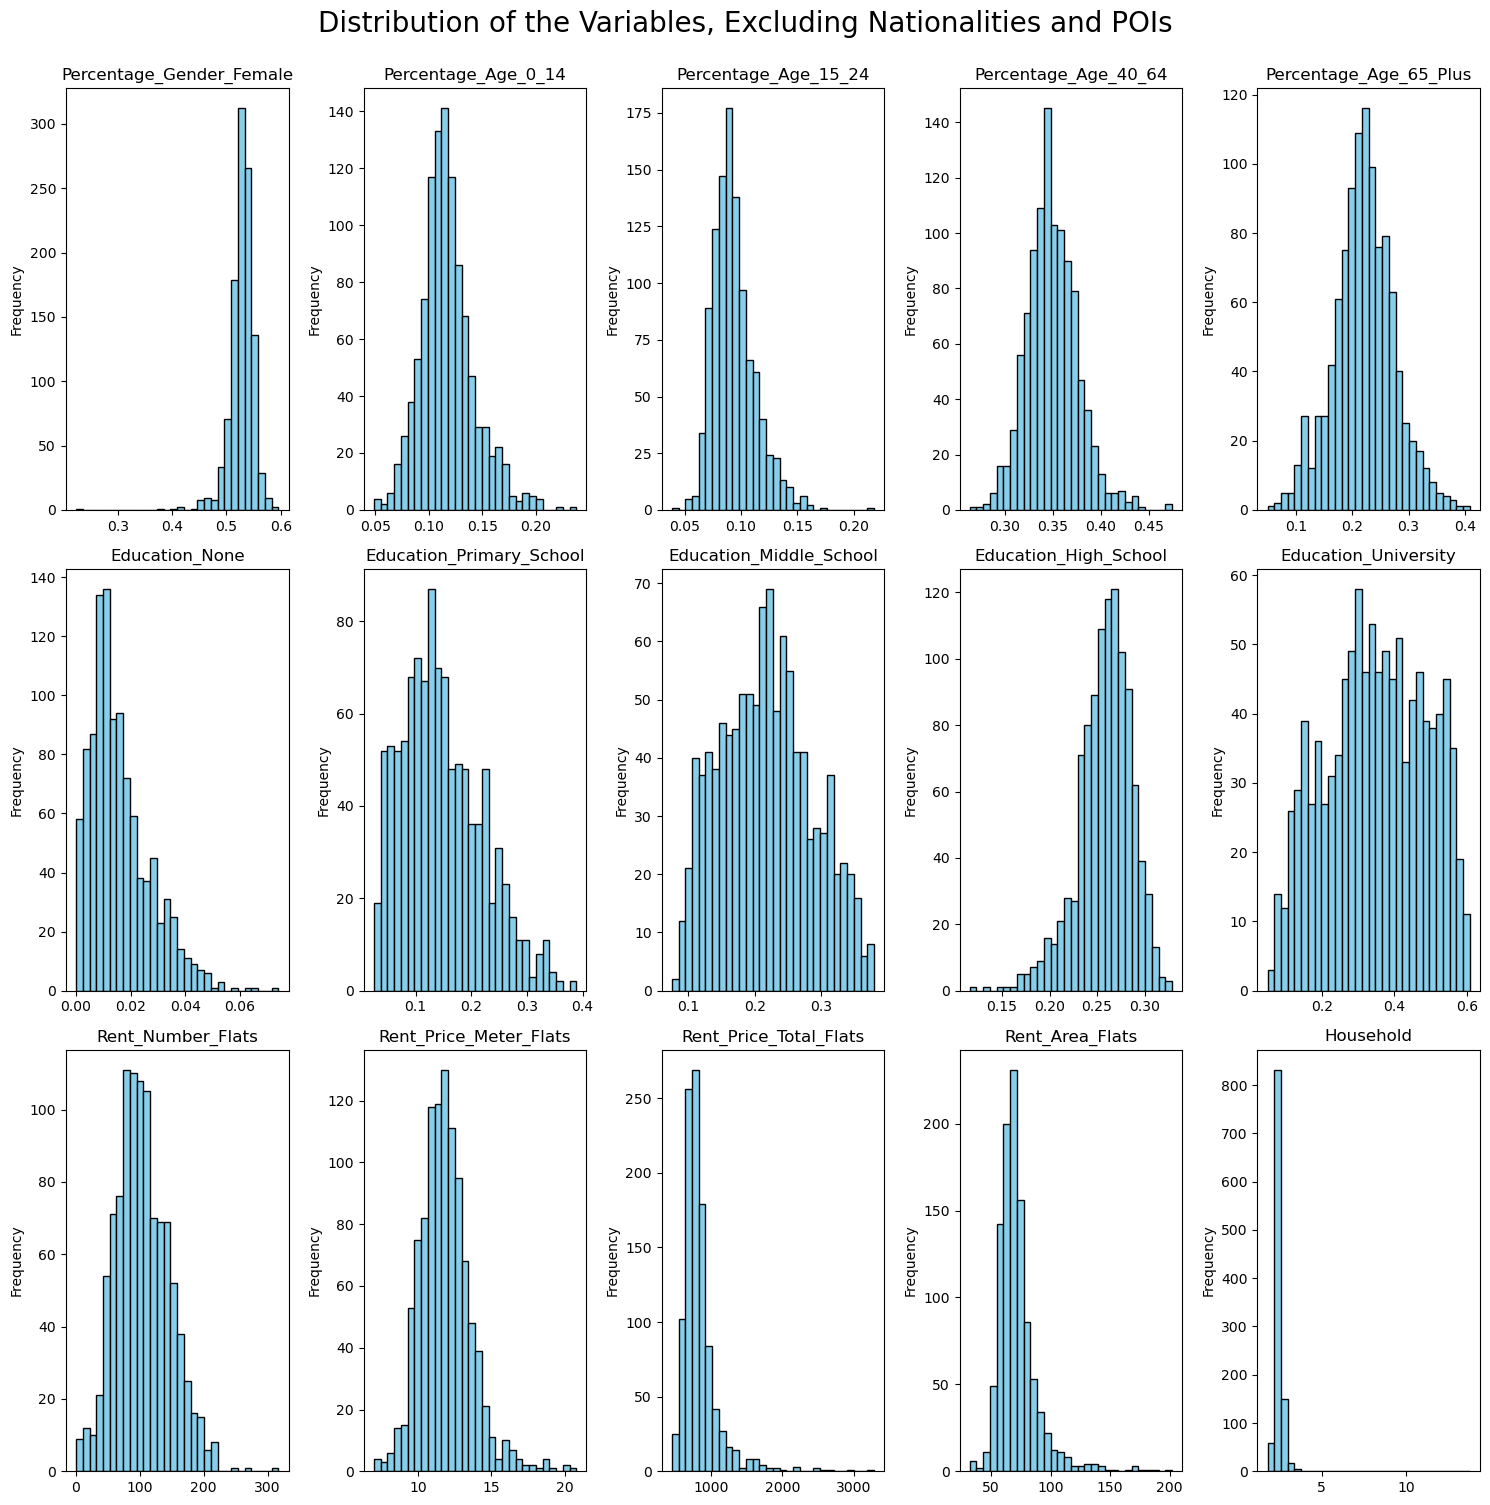

In [54]:
include_cols = [
    'Percentage_Gender_Female', 'Percentage_Age_0_14', 'Percentage_Age_15_24', 
    'Percentage_Age_40_64', 'Percentage_Age_65_Plus', 'Education_None', 
    'Education_Primary_School', 'Education_Middle_School', 'Education_High_School', 
    'Education_University', 'Rent_Number_Flats', 'Rent_Price_Meter_Flats', 
    'Rent_Price_Total_Flats', 'Rent_Area_Flats', 'Household'
]

sect_filtered = sect2[include_cols]

num_vars = sect_filtered.shape[1]
num_cols = 5
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
fig.suptitle('Distribution of the Variables, Excluding Nationalities and POIs', fontsize=20, y=1)
axes = axes.flatten()

for i, col in enumerate(sect_filtered.columns):
    axes[i].hist(sect_filtered[col].dropna(), bins=30, edgecolor='black', color='skyblue')  # Adjust bins as necessary
    axes[i].set_title(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(DIR_EDA / "distributions.png", format="png")

plt.show()


# Variables map distribution

In [25]:
merged_df.head()

Tag                                           geometry  Distance_Center  \
0  01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...         1.532922   
1  01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...         1.060772   
2  01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...         1.262231   
3  01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...         1.180517   
4  01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...         0.937494   

   POI_Daily_Food  POI_Daily_Others  POI_House_Equipment  POI_Clothing  \
0               6                 1                    0             0   
1               3                 2                    1             2   
2               9                 3                    1             2   
3              13                 4                    8             2   
4              20                 4                    2             2   

   POI_Culture  POI_Vehicles  POI_State_Agents  POI_Education  POI_Finances  \
0            2             0                 0              4             0   
1            1             0                 0              2             0   
2            3             0                 0              5             2   
3            5             0                 2              3             3   
4           38             0                 0              0             1   

   POI_Restaurants_Hotels  POI_Health  POI_Souvenirs_Thrift_Store  \
0                      33           2                           8   
1                      19           0                           3   
2                      20           3                           1   
3                      36           1                           3   
4                      42           1                          15   

   POI_Car_Parks  POI_Esthetics  POI_Sports  POI_Religion  POI_Administration  \
0              1              1           1             1                   4   
1              0              5           0             0                   0   
2              2              3           1             0                   1   
3              1              9           1             2                   3   
4              1             11           0             0                   2   

   Airbnb_Number  Percentage_Gender_Female  Percentage_Age_0_14  \
0             76                  0.464203             0.123172   
1             61                  0.486604             0.101376   
2             50                  0.458248             0.200466   
3             82                  0.450767             0.122317   
4            108                  0.460146             0.118053   

   Percentage_Age_15_24  Percentage_Age_40_64  Percentage_Age_65_Plus  \
0              0.087760              0.318707                0.143957   
1              0.126720              0.281680                0.133961   
2              0.130637              0.291824                0.108525   
3              0.111414              0.329472                0.100170   
4              0.112452              0.326583                0.126239   

   Household  Education_None  Education_Primary_School  \
0       2.52        0.011474                  0.211827   
1       2.60        0.023200                  0.220800   
2       3.23        0.012806                  0.296744   
3       2.65        0.010937                  0.227734   
4       2.45        0.015648                  0.246455   

   Education_Middle_School  Education_High_School  Education_University  \
0                 0.248897               0.202118              0.319506   
1                 0.251200               0.194400              0.301600   
2                 0.256129               0.192828              0.211123   
3                 0.246875               0.206250              0.292578   
4                 0.242054               0.194621              0.283619   

   Nationality_Spain  Nationality_Italy  Nationality_Fr

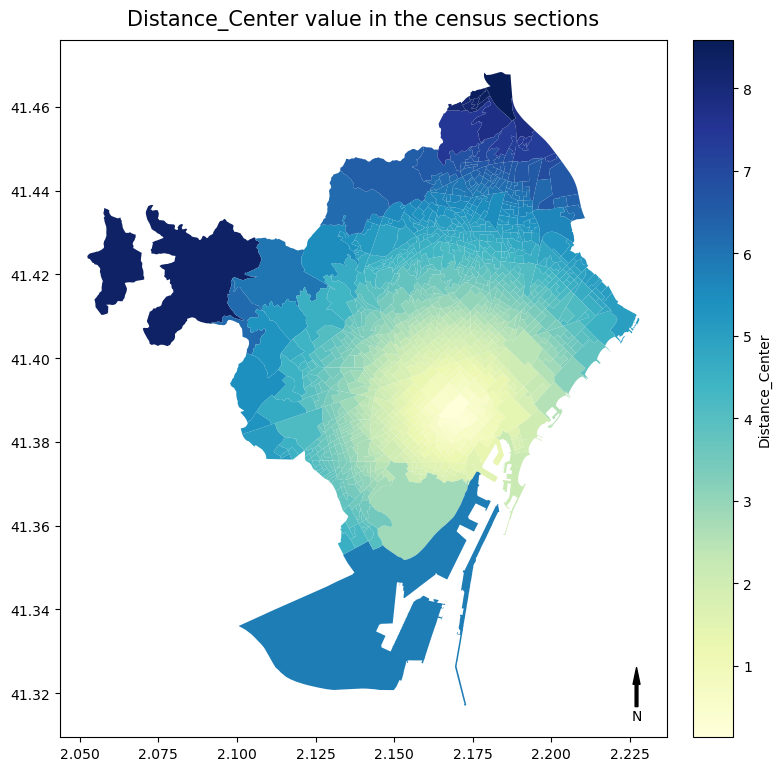

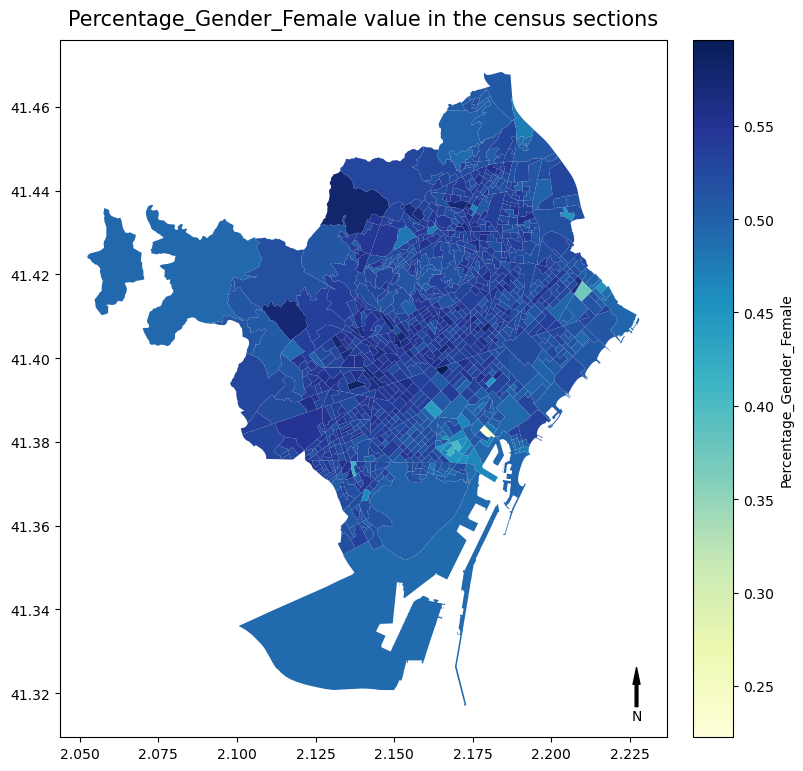

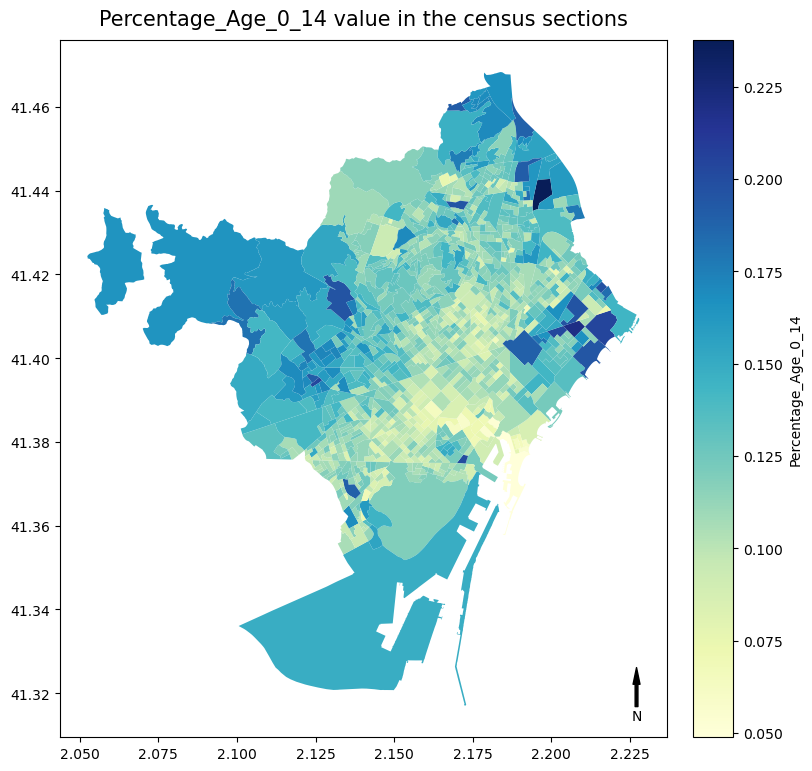

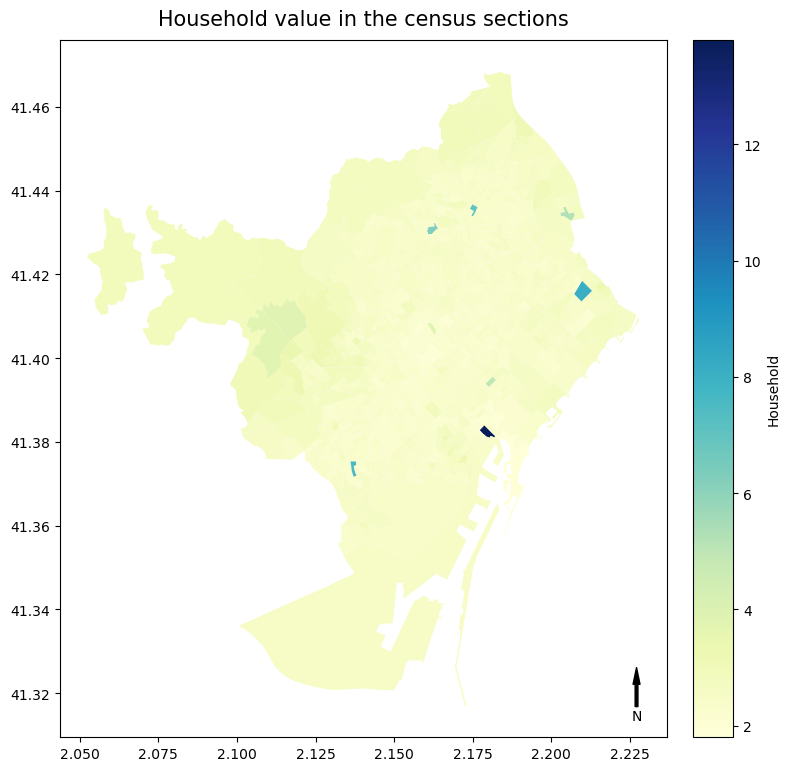

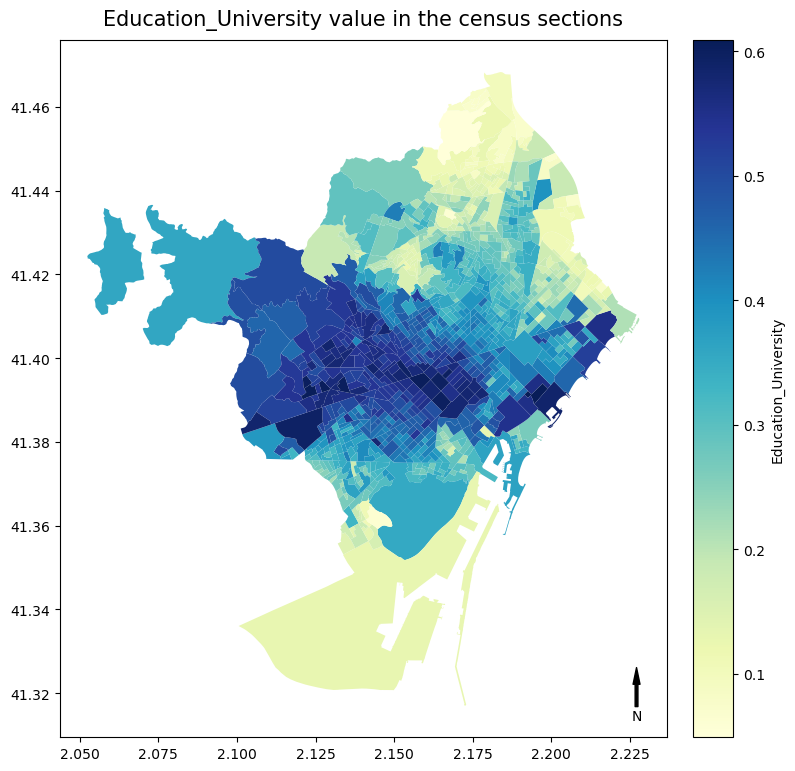

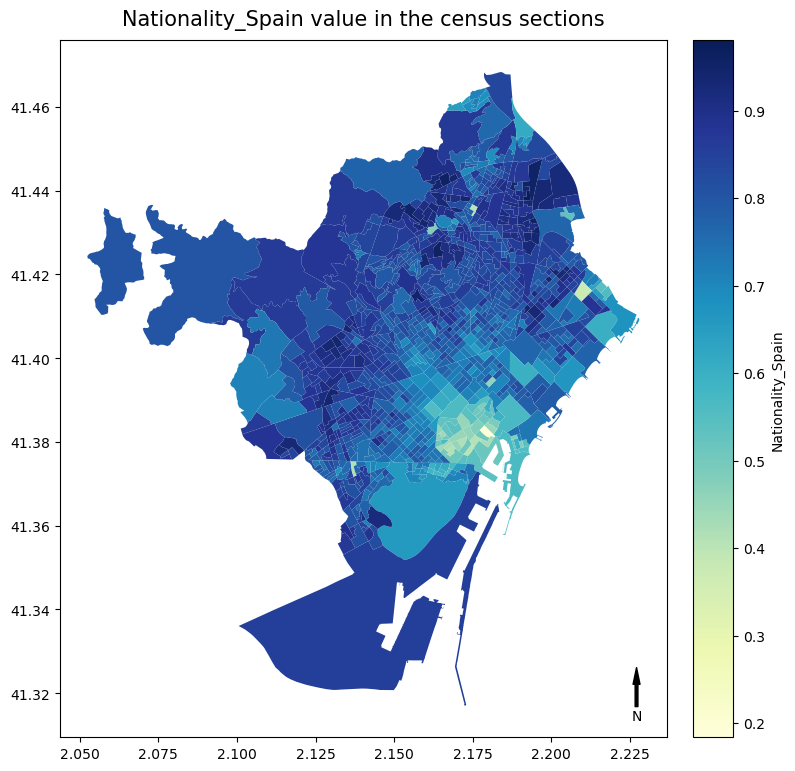

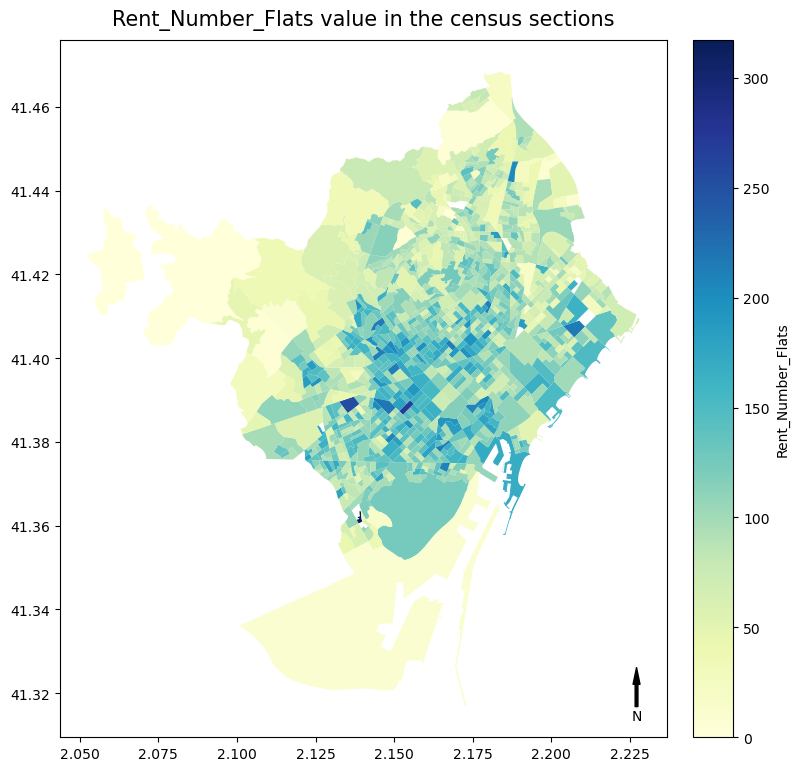

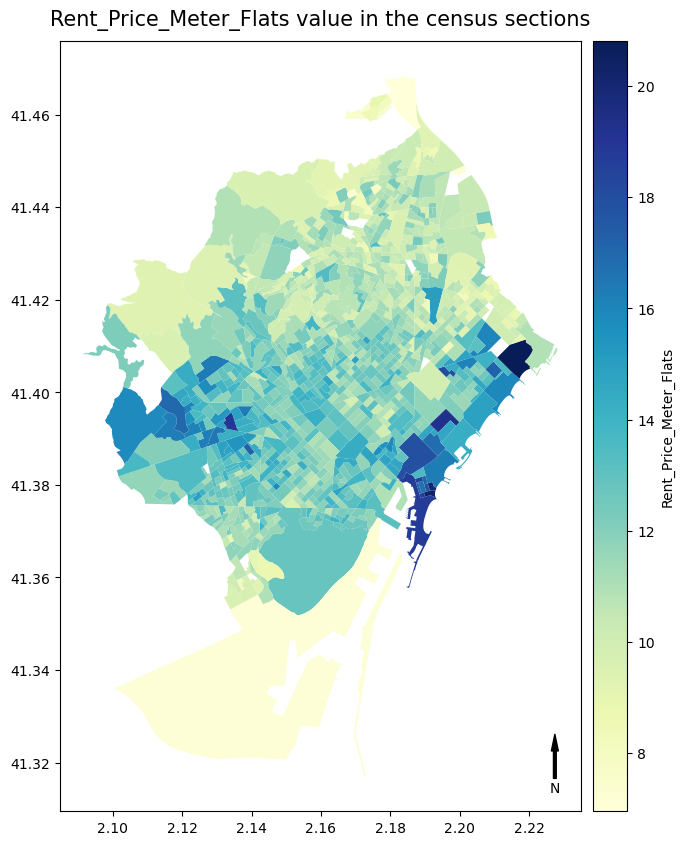

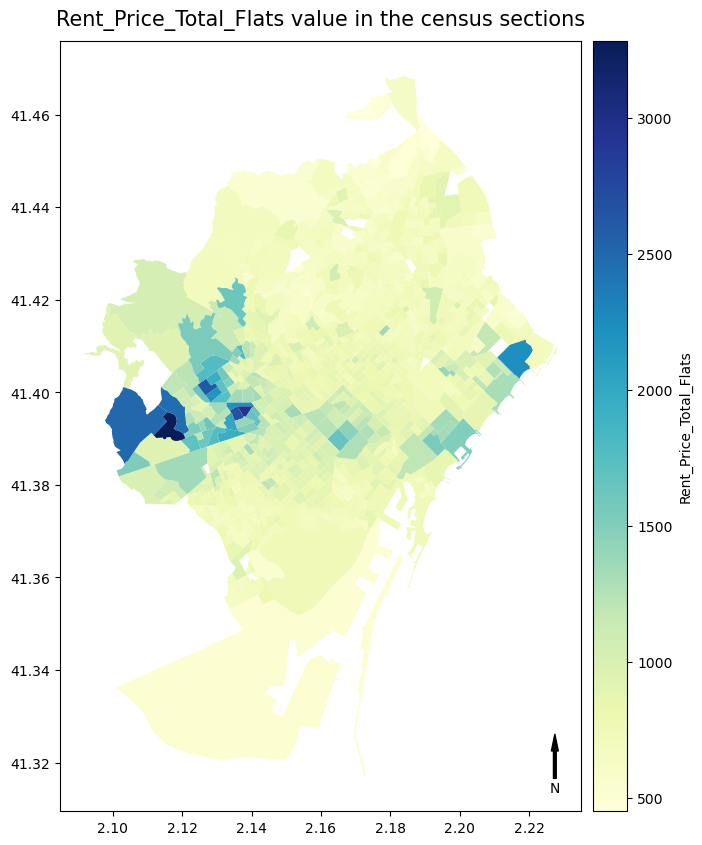

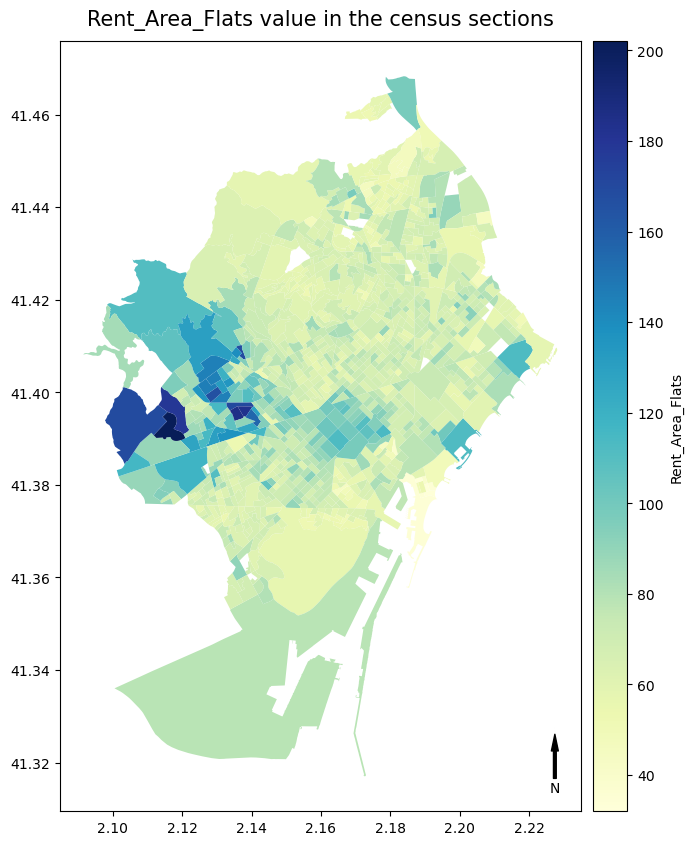

In [55]:
SAVE_FIGS = True
plot_var_map('Distance_Center')
plot_var_map('Percentage_Gender_Female')
plot_var_map('Percentage_Age_0_14')
plot_var_map('Household')
plot_var_map('Education_University')
plot_var_map('Nationality_Spain')
plot_var_map('Rent_Number_Flats')
plot_var_map('Rent_Price_Meter_Flats')
plot_var_map('Rent_Price_Total_Flats')
plot_var_map('Rent_Area_Flats')
SAVE_FIGS = False

# Districts of Barcelona

<Figure size 640x480 with 0 Axes>

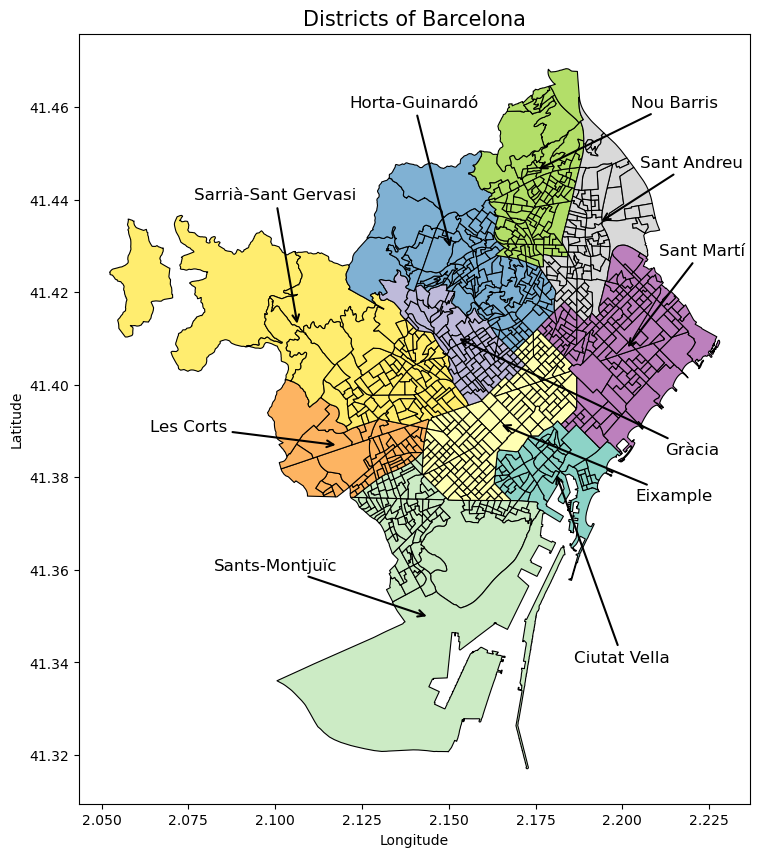

In [79]:
from matplotlib.colors import to_hex
from matplotlib.cm import get_cmap

gdf = gpd.read_file(DIR_DATA /"raw/BarcelonaCiutat_SeccionsCensals.csv")

# Rename the columns
gdf.rename(
    {
        "codi_districte": "N_district",
        "nom_districte": "Name_district",
        "codi_barri": "N_neighbourhood",
        "nom_barri": "Name_neighborhood",
        "codi_seccio_censal": "N_section"
    },
    axis=1,
    inplace=True,
)

# Convert the columns to strings with the desired format
gdf["Tag"] = gdf["N_district"].apply(lambda x: f"{int(x):02d}") + "_" + gdf["N_section"].apply(lambda x: f"{int(x):03d}")
gdf.sort_values(by=["Tag"], inplace=True)
gdf.set_index("Tag", inplace=True)
gdf = gdf[['Name_district', 'Name_neighborhood']]

gdf = geo_info.join(gdf, lsuffix='_left', rsuffix='_right')

cmap = get_cmap('Set3')
gdf.plot(column='Name_district', ax=ax, legend=False, cmap=cmap, linewidth=0.8, edgecolor='black')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='Name_district', ax=ax, legend=False, cmap='Set3', linewidth=0.8, edgecolor='black')

district_centroids = gdf.dissolve(by='Name_district').centroid
annotations = {
    "Ciutat Vella": (2.2, 41.34),
    "Eixample": (2.215, 41.375),
    "Sant Martí": (2.223, 41.428),
    "Horta-Guinardó": (2.14, 41.46),
    "Les Corts": (2.075, 41.39),
    "Sant Andreu": (2.22, 41.447),
    "Nou Barris": (2.215, 41.46),
    "Sants-Montjuïc": (2.1, 41.36),
    "Gràcia": (2.22, 41.385),
    "Sarrià-Sant Gervasi": (2.10, 41.44)}
for idx, geometry in district_centroids.items():
    if idx in annotations:
        ax.annotate(
            text=idx,
            xy=(geometry.x, geometry.y),
            xytext=annotations[idx],
            ha='center',
            fontsize=12,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5)
        )

# Add titles and labels
ax.set_title('Districts of Barcelona', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "districts_map.png", format="png")

plt.show()

In [61]:
gdf

geometry Name_district  \
Tag                                                                       
01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...  Ciutat Vella   
01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...  Ciutat Vella   
01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...  Ciutat Vella   
01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...  Ciutat Vella   
01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...  Ciutat Vella   
...                                                   ...           ...   
10_143  POLYGON ((2.20926 41.42519, 2.20909 41.42534, ...    Sant Martí   
10_234  POLYGON ((2.18971 41.40755, 2.18948 41.40759, ...    Sant Martí   
10_235  POLYGON ((2.21303 41.41093, 2.21190 41.41180, ...    Sant Martí   
10_236  POLYGON ((2.21203 41.41004, 2.21079 41.41096, ...    Sant Martí   
10_237  POLYGON ((2.20983 41.41847, 2.20842 41.41953, ...    Sant Martí   

                                   Name_neighborhood  
Tag                                                   
01_001                                      el Raval  
01_002                                      el Raval  
01_003                                      el Raval  
01_004                                      el Raval  
01_005                                      el Raval  
...                                              ...  
10_143                           la Verneda i la Pau  
10_234                                       el Clot  
10_235  Diagonal Mar i el Front Marítim del Poblenou  
10_236  Diagonal Mar i el Front Marítim del Poblenou  
10_237                       Provençals del Poblenou  

[1068 rows x 3 columns]

In [73]:
merged_df2 = sect.join(gdf, on='Tag')
grouped_df = merged_df2.groupby('Name_district')['Airbnb_Number'].sum().sort_values(ascending=False).reset_index()
grouped_df

Name_district  Airbnb_Number
0             Eixample           5847
1         Ciutat Vella           3841
2       Sants-Montjuïc           1619
3           Sant Martí           1367
4               Gràcia           1362
5  Sarrià-Sant Gervasi            815
6       Horta-Guinardó            421
7            Les Corts            318
8          Sant Andreu            223
9           Nou Barris            159

In [32]:
district_centroids.items

<bound method Series.items of Name_district
Ciutat Vella           POINT (2.18073 41.38113)
Eixample               POINT (2.16447 41.39159)
Gràcia                 POINT (2.15222 41.41026)
Horta-Guinardó         POINT (2.15057 41.42916)
Les Corts              POINT (2.11824 41.38693)
Nou Barris             POINT (2.17507 41.44631)
Sant Andreu            POINT (2.19331 41.43504)
Sant Martí             POINT (2.20104 41.40763)
Sants-Montjuïc         POINT (2.14444 41.34980)
Sarrià-Sant Gervasi    POINT (2.10651 41.41260)
dtype: geometry>